### Leveraging pretrained models with transfer learning

In [1]:

import lightning as L
import torch
import torchmetrics
import torch.nn.functional as F
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms

from shared_utilities import LightningModel, Cifar10DataModule, plot_loss_and_acc

In [20]:
L.LightningDataModule?

Init signature: L.LightningDataModule() -> None
Docstring:     
A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is
consistent data splits, data preparation and transforms across models.

Example::

    class MyDataModule(LightningDataModule):
        def __init__(self):
            super().__init__()
        def prepare_data(self):
            # download, split, etc...
            # only called on 1 GPU/TPU in distributed
        def setup(self, stage):
            # make assignments here (val/train/test split)
            # called on every process in DDP
        def train_dataloader(self):
            train_split = Dataset(...)
            return DataLoader(train_split)
        def val_dataloader(self):
            val_split = Dataset(...)
            return DataLoader(val_split)
        def test_dataloader(self):
            test_split = Dataset(...)
            return DataLoader(test_split)
        def teardown(self):
   

In [21]:
entrypoints = torch.hub.list('pytorch/vision', force_reload=True)

for e in entrypoints:
    if 'convnext' in e:
        print(e)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /home/codespace/.cache/torch/hub/main.zip


convnext_base
convnext_large
convnext_small
convnext_tiny


In [22]:
pytorch_model  = torch.hub.load('pytorch/vision', 'convnext_tiny', weights=None)

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_main


In [23]:
L.pytorch.seed_everything(33)


dm=Cifar10DataModule(batch_size=100, num_workers=1)
dm.prepare_data()
dm.setup()

Global seed set to 33


Files already downloaded and verified


### Checkout the Data

In [24]:
for images, labels in dm.train_dataloader():
    break

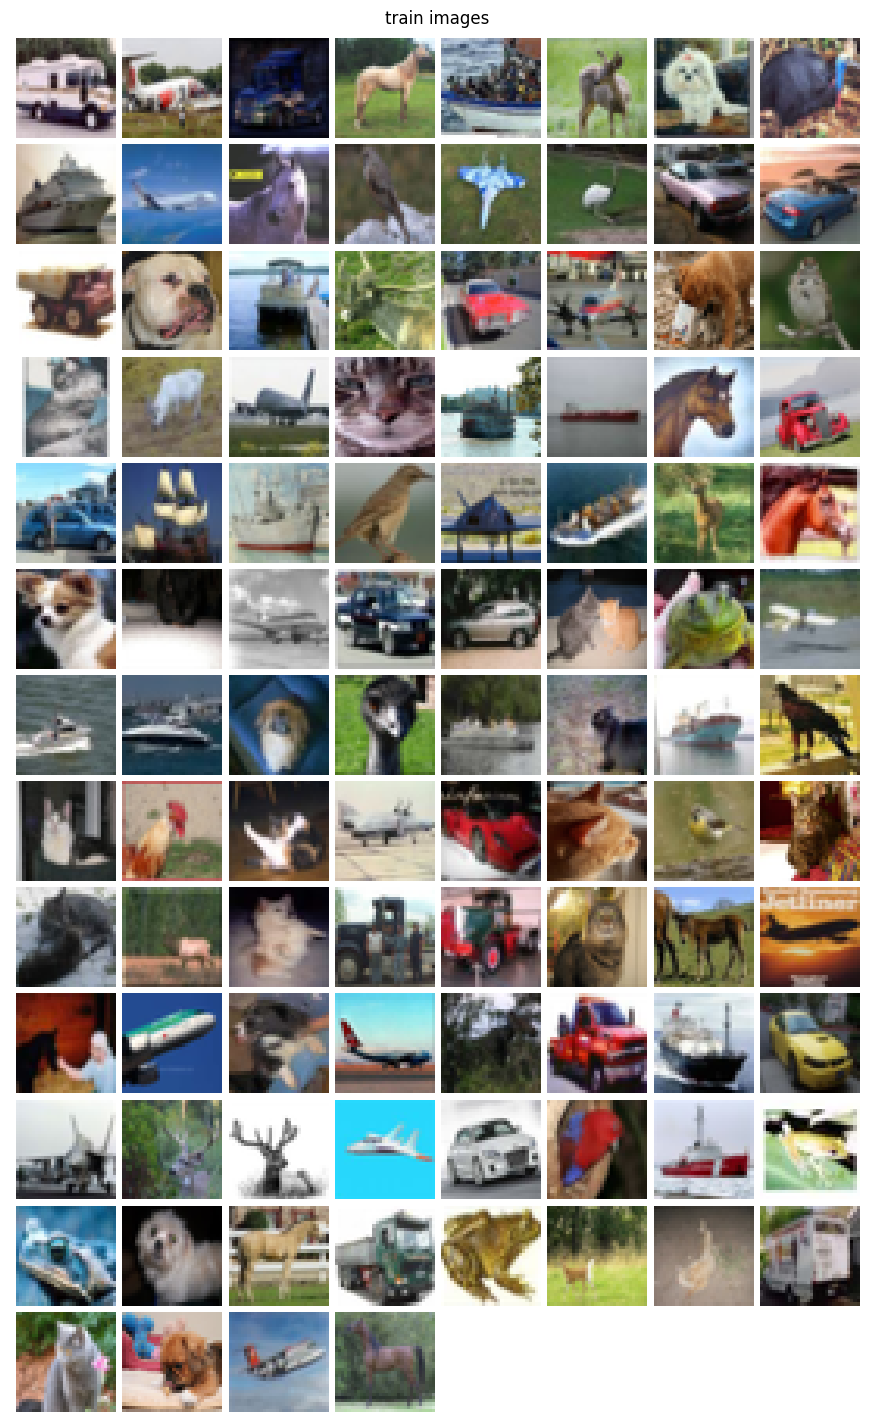

In [29]:
plt.figure(figsize=(18,18))
plt.title("train images")
plt.axis('off')
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:100],
    padding=2,
    pad_value=1.0,
    normalize=True),
    (1,2,0)))
plt.show()

In [30]:
images[0].shape

torch.Size([3, 32, 32])

### Prepare the Trainer

In [31]:
L.Trainer?

Init signature:
L.Trainer(
    *,
    accelerator: Union[str, lightning.pytorch.accelerators.accelerator.Accelerator] = 'auto',
    strategy: Union[str, lightning.pytorch.strategies.strategy.Strategy] = 'auto',
    devices: Union[List[int], str, int] = 'auto',
    num_nodes: int = 1,
    precision: Union[Literal[64, 32, 16], Literal['16-mixed', 'bf16-mixed', '32-true', '64-true'], Literal['64', '32', '16', 'bf16']] = '32-true',
    logger: Union[lightning.pytorch.loggers.logger.Logger, Iterable[lightning.pytorch.loggers.logger.Logger], bool, NoneType] = None,
    callbacks: Union[List[lightning.pytorch.callbacks.callback.Callback], lightning.pytorch.callbacks.callback.Callback, NoneType] = None,
    fast_dev_run: Union[int, bool] = False,
    max_epochs: Optional[int] = None,
    min_epochs: Optional[int] = None,
    max_steps: int = -1,
    min_steps: Optional[int] = None,
    max_time: Union[str, datetime.timedelta, Dict[str, int], NoneType] = None,
    limit_train_batches: Union[int

In [32]:
dm=Cifar10DataModule(batch_size=64, height_width=(128,128))
dm.prepare_data()
dm.setup()

lightning_model=LightningModel(model=pytorch_model, learning_rate=0.2)

trainer=  L.Trainer(
    max_epochs=5,
    logger=CSVLogger(save_dir='logs/', name='my_convnext_1'),
    deterministic=True
)



Files already downloaded and verified


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(model=lightning_model, datamodule=dm)

Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ConvNeXt           | 28.6 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
28.6 M    Trainable params
0         Non-trainable params
28.6 M    Total params
114.357   Total estimated model params size (MB)


Epoch 0:   0%|          | 2/703 [00:53<5:11:53, 26.70s/it, v_num=0]        

/usr/local/python/3.10.8/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [34]:
plot_loss_and_acc(trainer.logger.log_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/my_convnext_1/version_0/metrics.csv'

## Part2---Only tuning the Last Layer

In [52]:
#We will start from loading the model

pytorch_model = torch.hub.load('pytorch/vision:v0.13.0', 'convnext_tiny', weights='IMAGENET1K_V1', force_reload=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /home/codespace/.cache/torch/hub/v0.13.0.zip


In [53]:
pytorch_model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [54]:
#freeze all the layers except the last one

for param in pytorch_model.parameters():
    param.requires_grad = False

pytorch_model.classifier[2]=torch.nn.Linear(768, 10)

In [55]:
pytorch_model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

### Custom Transform

##### Why? because there is a preprocessing protocol that was used for pre_training the model

In [66]:
from torchvision.models import convnext_tiny,ConvNeXt_Tiny_Weights

weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
preprocesss_transform=weights.transforms()
preprocesss_transform

ImageClassification(
    crop_size=[224]
    resize_size=[236]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [67]:
#Now we will use this transform to transform out dataset in 
##order to be usable for convnext_tiny

In [69]:
L.pytorch.seed_everything(2349786)


dm = Cifar10DataModule(batch_size=64,
                       train_transform=preprocesss_transform,
                       test_transform=preprocesss_transform
                      )

dm.prepare_data()
dm.setup()

Global seed set to 2349786


Files already downloaded and verified


In [70]:
trainer = L.Trainer(
        max_epochs=5,
        logger=CSVLogger(save_dir='logs/',name='convnext_last_layer_ft'),
        deterministic=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:

trainer.fit(model=lightning_model, datamodule=dm)

Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ConvNeXt           | 28.6 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
28.6 M    Trainable params
0         Non-trainable params
28.6 M    Total params
114.357   Total estimated model params size (MB)


Epoch 0:   0%|          | 0/703 [00:00<?, ?it/s]                           

[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


## Part3__Using Pretrained weights as well  as Fine Tuning all of them

In [3]:
for e in torch.hub.list('pytorch/vision', force_reload=True):
    print(e)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /home/codespace/.cache/torch/hub/main.zip


alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
deeplabv3_mobilenet_v3_large
deeplabv3_resnet101
deeplabv3_resnet50
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
fcn_resnet101
fcn_resnet50
get_model_weights
get_weight
googlenet
inception_v3
lraspp_mobilenet_v3_large
maxvit_t
mc3_18
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mvit_v1_b
mvit_v2_s
r2plus1d_18
r3d_18
raft_large
raft_small
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_128gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet_y_3_2gf
regnet_y_400mf
regnet_y_800mf
regnet_y_8gf
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext101_64x4d
resnext50_32x4d
s3d
shufflenet_v2_x0_5
shufflenet_v2_x1_0
sh

In [6]:
# Lets checkout the densenet models

pytorch_model = torch.hub.load(repo_or_dir='pytorch/vision',model='densenet201', weights='IMAGENET1K_V1')

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/codespace/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 184MB/s]


In [11]:
len_params=0
for params in pytorch_model.parameters():
    len_params+=1

In [13]:
len_params

604

In [18]:
# for params in pytorch_model.parameters():
#     params.requires_grad=False

# the above two lines freezes all the layers 

#But here in part 3 we dont need to freeze the layers, because we want to finetune all the layers


pytorch_model.classifier=nn.Linear(1920,10)

In [19]:
pytorch_model.classifier

Linear(in_features=1920, out_features=10, bias=True)

## Custom Transform



In [20]:
## Keep in mind to make pre processing transforms to the dataset in order to be able to make fit to the model

In [23]:
from torchvision.models import densenet201, DenseNet161_Weights
weights = DenseNet161_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()

In [24]:
preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
L.pytorch.seed_everything(4897)

dm = Cifar10DataModule(batch_size=64,
                       train_transform=preprocess_transform,
                       test_transform=preprocess_transform)
dm.prepare_data()
dm.setup()


lightning_model = LightningModel(model=pytorch_model, learning_rate=0.2)

trainer = L.Trainer(
    max_epochs=5,
    logger=CSVLogger(save_dir="logs/", name='densenet201_full_finetune'),
    deterministic=True)

trainer.fit(model=lightning_model, datamodule=dm)

Global seed set to 4897


Files already downloaded and verified


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | DenseNet           | 18.1 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params
72.449    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/703 [00:00<?, ?it/s]                           

[rank: 0] Received SIGTERM: 15
